In [1]:
import numpy as np
import pandas as pd
import time
import ast
from multiprocessing import *
import sys
from LumA_Functions import *
import scipy 
from scipy.stats import mannwhitneyu as wrs
from scipy.stats import spearmanr as spearman
import operator
from tqdm import tqdm
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Part 1: Data Preprocessing and Selecting 1000 Features

In [2]:
# Read comma separated data
data = pd.read_csv('data/TCGA.csv', index_col=False)
data_target = pd.read_csv('data/sampleinfo_TCGA_t.csv')
data = data.set_index('Unnamed: 0').T

##### Adding the target column to the dataframe and drop missing data

In [3]:
data['isLumA'] = 0
data = data.dropna(axis=1)
data 

Unnamed: 0        A2M     A4GNT      AAAS      AACS     AADAC      AAK1  \
DO1249      11.316095  1.609438  6.694562  7.528332  1.098612  8.245909   
DO1250      10.501857  0.000000  7.628031  7.808729  1.386294  8.221479   
DO1251      10.277840  1.386294  7.883823  8.434246  0.000000  8.885994   
DO1252       9.619399  1.386294  7.024649  7.598399  5.802118  7.572503   
DO1253      11.964657  2.302585  7.975221  8.215277  6.354370  8.688959   
...               ...       ...       ...       ...       ...       ...   
DO6204      10.092536  1.098612  7.289611  9.010303  3.970292  8.718173   
DO6213      10.654833  1.791759  7.329094  7.842279  0.000000  8.391176   
DO6222       9.471088  0.000000  7.153834  7.785305  0.000000  7.112327   
DO6231      10.026811  1.791759  7.951911  9.146761  2.639057  7.949444   
DO6240      10.704143  1.098612  7.722678  7.731492  2.302585  8.607399   

Unnamed: 0      AAMP       AARS  AASDHPPT      AASS  ...   ZSCAN18   ZSCAN5A  \
DO1249      9.151651   9.341719  7.727976  5.834811  ...  7.583756  6.278521   
DO1250      8.919988   8.667164  7.551712  6.047372  ...  8.862625  5.105945   
DO1251      9.261794   9.560927  7.763871  5.560682  ...  8.123854  5.424950   
DO1252      8.779557   8.572817  7.338238  5.926926  ...  7.072422  4.828314   
DO1253      9.241936   9.542948  8.233769  7.686162  ...  8.972337  5.616771   
...              ...        ...       ...       ...  ...       ...       ...   
DO6204      8.503094  10.362462  8.318986  5.869297  ...  7.096721  4.672829   
DO6213      8.647344   9.273785  7.829233  5.501258  ...  6.411818  4.812184   
DO6222      8.439448   8.027150  7.984122  6.411818  ...  6.546785  4.488636   
DO6231      9.317130   9.828602  8.250620  6.161207  ...  8.815964  6.063785   
DO6240      8.871084   9.841240  7.744570  5.963579  ...  7.472501  4.836282   

Unnamed: 0      ZW10     ZWINT      ZXDA      ZXDC        ZYX     ZZEF1  \
DO1249      7.741534  8.044305  5.407172  7.763446   9.966885  8.080547   
DO1250      6.987490  7.888710  5.613128  8.213653   9.028459  8.941284   
DO1251      6.845880  8.292799  5.365976  8.794673   9.356948  8.409162   
DO1252      6.666957  7.576097  4.204693  7.356280   9.452816  7.071573   
DO1253      7.855545  7.286192  5.717028  8.432506  10.184523  8.819222   
...              ...       ...       ...       ...        ...       ...   
DO6204      7.795647  7.448916  5.493061  7.976252   9.378985  9.340140   
DO6213      7.257003  7.078342  5.752573  8.130942   8.927447  8.614683   
DO6222      7.194437  6.967909  5.087596  7.545390   8.804475  7.889459   
DO6231      7.909489  8.991562  5.262690  9.055556   8.788898  8.329899   
DO6240      7.329750  7.687539  5.438079  8.299535   9.435642  8.443547   

Unnamed: 0      ZZZ3  isLumA  
DO1249      8.033334       0  
DO1250      8.165364       0  
DO1251      8.442039       0  
DO1252      7.021084       0  
DO1253      8.623893       0  
...              ...     ...  
DO6204      8.192847       0  
DO6213      8.695507       0  
DO6222      7.973500       0  
DO6231      7.887959       0  
DO6240      8.445053       0  

[981 rows x 9533 columns]

##### Add the LumA information in the 'Target' column. We classify LumA = 1 and ~LumA = 0

In [4]:
data_target

Unnamed: 0 samplename    time  event   ER    Lympho  PAM50  cluster2  \
0             1     DO1249   397.0    0.0  1.0  5.262716  Basal         4   
1             2     DO1250   990.0    0.0  2.0  5.776434   LumB         5   
2             3     DO1251  1124.0    0.0  2.0  3.817553   LumB         4   
3             4     DO1252    54.0    0.0  1.0  5.170401  Basal         4   
4             5     DO1253   786.0    1.0  2.0  6.241850   LumA         5   
..          ...        ...     ...    ...  ...       ...    ...       ...   
976         977     DO6204   366.0    0.0  1.0  5.966065   Her2         5   
977         978     DO6213   448.0    0.0  2.0  4.421733   LumA         4   
978         979     DO6222  2548.0    0.0  2.0  5.367675   LumA         5   
979         980     DO6231   187.0    0.0  NaN  4.924237   LumB         4   
980         981     DO6240   365.0    0.0  2.0  5.887511   LumB         5   

     round2       ROR  
0         4  0.156605  
1         4 -0.051804  
2         4  0.139002  
3         4  0.309438  
4         5 -0.375173  
..      ...       ...  
976       5  0.170695  
977       4 -0.284571  
978       4 -0.305462  
979       4  0.433196  
980       5  0.123222  

[981 rows x 10 columns]

In [5]:
for index in range(data_target.shape[0]):
    if data_target['PAM50'][index] == "LumA":
        data['isLumA'][index] = 1

data.head(10)

Unnamed: 0        A2M     A4GNT      AAAS      AACS     AADAC      AAK1  \
DO1249      11.316095  1.609438  6.694562  7.528332  1.098612  8.245909   
DO1250      10.501857  0.000000  7.628031  7.808729  1.386294  8.221479   
DO1251      10.277840  1.386294  7.883823  8.434246  0.000000  8.885994   
DO1252       9.619399  1.386294  7.024649  7.598399  5.802118  7.572503   
DO1253      11.964657  2.302585  7.975221  8.215277  6.354370  8.688959   
DO1254      11.258511  2.484907  8.187855  8.807173  2.772589  8.404696   
DO1255      10.602169  2.197225  7.630947  7.322510  0.000000  8.210940   
DO1256      10.522315  0.693147  7.576097  9.535174  3.688879  8.374477   
DO1257      11.644901  1.791759  8.227376  8.580168  1.609438  8.798304   
DO1259      10.406533  0.693147  7.702556  8.509766  0.000000  8.109826   

Unnamed: 0      AAMP      AARS  AASDHPPT      AASS  ...   ZSCAN18   ZSCAN5A  \
DO1249      9.151651  9.341719  7.727976  5.834811  ...  7.583756  6.278521   
DO1250      8.919988  8.667164  7.551712  6.047372  ...  8.862625  5.105945   
DO1251      9.261794  9.560927  7.763871  5.560682  ...  8.123854  5.424950   
DO1252      8.779557  8.572817  7.338238  5.926926  ...  7.072422  4.828314   
DO1253      9.241936  9.542948  8.233769  7.686162  ...  8.972337  5.616771   
DO1254      9.452109  9.821518  8.178358  7.797702  ...  8.436850  6.270988   
DO1255      8.863757  9.984145  7.766417  6.148468  ...  7.005789  5.583496   
DO1256      8.934455  9.509482  8.256607  6.224558  ...  7.358194  5.204007   
DO1257      9.237858  9.648337  8.415825  8.069655  ...  8.328209  5.669881   
DO1259      8.828348  9.338118  7.657283  7.435438  ...  8.324336  4.990433   

Unnamed: 0      ZW10     ZWINT      ZXDA      ZXDC        ZYX     ZZEF1  \
DO1249      7.741534  8.044305  5.407172  7.763446   9.966885  8.080547   
DO1250      6.987490  7.888710  5.613128  8.213653   9.028459  8.941284   
DO1251      6.845880  8.292799  5.365976  8.794673   9.356948  8.409162   
DO1252      6.666957  7.576097  4.204693  7.356280   9.452816  7.071573   
DO1253      7.855545  7.286192  5.717028  8.432506  10.184523  8.819222   
DO1254      7.684324  7.519692  6.236370  8.964696   9.651687  8.980927   
DO1255      7.905810  7.483244  4.897840  7.951559   9.924515  8.639942   
DO1256      8.095599  8.136811  6.261492  8.274357   9.483797  9.004545   
DO1257      7.787382  7.694848  6.304449  9.003562  10.020515  9.352881   
DO1259      7.054450  8.484463  5.598422  8.578665   9.248407  8.314832   

Unnamed: 0      ZZZ3  isLumA  
DO1249      8.033334       0  
DO1250      8.165364       0  
DO1251      8.442039       0  
DO1252      7.021084       0  
DO1253      8.623893       1  
DO1254      8.501673       0  
DO1255      7.874739       0  
DO1256      8.665096       0  
DO1257      8.969287       0  
DO1259      8.384347       0  

[10 rows x 9533 columns]

### Data Visualisation:

[603 378]


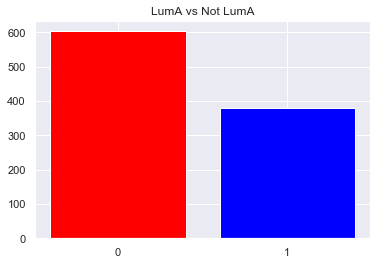

In [6]:
t = data['isLumA']
values, counts = np.unique(t, return_counts=True)
print(counts)
plt.bar(x=values,height=counts, color=["Red", "Blue"])
plt.xticks([0,1])
plt.title("LumA vs Not LumA")
plt.show()

##### Removing all columns with zero variance (i.e any constant value column)

In [7]:
# Removing zero variance cols
data = data.loc[:, (data != data.iloc[0]).any()] 
data 

Unnamed: 0        A2M     A4GNT      AAAS      AACS     AADAC      AAK1  \
DO1249      11.316095  1.609438  6.694562  7.528332  1.098612  8.245909   
DO1250      10.501857  0.000000  7.628031  7.808729  1.386294  8.221479   
DO1251      10.277840  1.386294  7.883823  8.434246  0.000000  8.885994   
DO1252       9.619399  1.386294  7.024649  7.598399  5.802118  7.572503   
DO1253      11.964657  2.302585  7.975221  8.215277  6.354370  8.688959   
...               ...       ...       ...       ...       ...       ...   
DO6204      10.092536  1.098612  7.289611  9.010303  3.970292  8.718173   
DO6213      10.654833  1.791759  7.329094  7.842279  0.000000  8.391176   
DO6222       9.471088  0.000000  7.153834  7.785305  0.000000  7.112327   
DO6231      10.026811  1.791759  7.951911  9.146761  2.639057  7.949444   
DO6240      10.704143  1.098612  7.722678  7.731492  2.302585  8.607399   

Unnamed: 0      AAMP       AARS  AASDHPPT      AASS  ...   ZSCAN18   ZSCAN5A  \
DO1249      9.151651   9.341719  7.727976  5.834811  ...  7.583756  6.278521   
DO1250      8.919988   8.667164  7.551712  6.047372  ...  8.862625  5.105945   
DO1251      9.261794   9.560927  7.763871  5.560682  ...  8.123854  5.424950   
DO1252      8.779557   8.572817  7.338238  5.926926  ...  7.072422  4.828314   
DO1253      9.241936   9.542948  8.233769  7.686162  ...  8.972337  5.616771   
...              ...        ...       ...       ...  ...       ...       ...   
DO6204      8.503094  10.362462  8.318986  5.869297  ...  7.096721  4.672829   
DO6213      8.647344   9.273785  7.829233  5.501258  ...  6.411818  4.812184   
DO6222      8.439448   8.027150  7.984122  6.411818  ...  6.546785  4.488636   
DO6231      9.317130   9.828602  8.250620  6.161207  ...  8.815964  6.063785   
DO6240      8.871084   9.841240  7.744570  5.963579  ...  7.472501  4.836282   

Unnamed: 0      ZW10     ZWINT      ZXDA      ZXDC        ZYX     ZZEF1  \
DO1249      7.741534  8.044305  5.407172  7.763446   9.966885  8.080547   
DO1250      6.987490  7.888710  5.613128  8.213653   9.028459  8.941284   
DO1251      6.845880  8.292799  5.365976  8.794673   9.356948  8.409162   
DO1252      6.666957  7.576097  4.204693  7.356280   9.452816  7.071573   
DO1253      7.855545  7.286192  5.717028  8.432506  10.184523  8.819222   
...              ...       ...       ...       ...        ...       ...   
DO6204      7.795647  7.448916  5.493061  7.976252   9.378985  9.340140   
DO6213      7.257003  7.078342  5.752573  8.130942   8.927447  8.614683   
DO6222      7.194437  6.967909  5.087596  7.545390   8.804475  7.889459   
DO6231      7.909489  8.991562  5.262690  9.055556   8.788898  8.329899   
DO6240      7.329750  7.687539  5.438079  8.299535   9.435642  8.443547   

Unnamed: 0      ZZZ3  isLumA  
DO1249      8.033334       0  
DO1250      8.165364       0  
DO1251      8.442039       0  
DO1252      7.021084       0  
DO1253      8.623893       1  
...              ...     ...  
DO6204      8.192847       0  
DO6213      8.695507       1  
DO6222      7.973500       1  
DO6231      7.887959       0  
DO6240      8.445053       0  

[981 rows x 9530 columns]

##### Using WRS to reduce the features to 1000:

In [8]:
X = data.drop('isLumA', axis=1)
y = data['isLumA']
# Seperate the data into two class, luminal-A and not-Luminal-A
lumA, not_lumA = X[y == 1], X[y != 1] # cahnge X and y and rename B
lumA.shape, not_lumA.shape

((378, 9529), (603, 9529))

In [9]:
wrs_dict = {}
for col in X.columns.values:
    current_wrs = wrs(lumA[col], not_lumA[col], alternative='two-sided') 
    wrs_dict[col] = current_wrs[1] # add p-value 
sorted_wrs_res = sorted(wrs_dict.items(), key=operator.itemgetter(1))

In [10]:
corr_threshold = 0.5
count_threshold = 1000
sorted_wrs_res[:10]

[('MYBL2', 1.0550495601009135e-93),
 ('CDC45', 1.2223762406048338e-93),
 ('UBE2C', 1.5116466865017539e-93),
 ('CCNB2', 2.999074471054578e-93),
 ('CENPA', 5.773170270148125e-92),
 ('FOXM1', 1.7288447187348226e-89),
 ('BIRC5', 4.578971660758119e-89),
 ('PLK1', 6.77908839489031e-89),
 ('KIF2C', 2.0803946473367871e-88),
 ('TPX2', 1.6987120849437872e-87)]

In [11]:
 try:
    final_set = np.loadtxt('data/TCGA_1000.csv',dtype='U', delimiter=',')
except:
    print("File not found, finding the best 1000 features now.")
    final_set = [sorted_wrs_res[0][0]]
    c = 1
    print(c,":",final_set[0])
    t = tqdm(sorted_wrs_res[1:])
    for gene, _ in t:
        rhos = [spearman(X[gene], X[selected_gene])[0] for selected_gene in final_set]
        max_rho = max(rhos)
        if max_rho < corr_threshold:
            final_set.append(gene)
            c += 1
            print(c,":",gene)
            t.set_postfix({"Gene Found":gene, "Current C": c})
        if c == count_threshold:
            break
            
    # save to csv file
    np.savetxt('data/TCGA_1000.csv', np.array(final_set), fmt="%10s", delimiter=',')
final_set = [str(final_set[i]).lstrip() for i in range(len(final_set))]

In [12]:
print(final_set[:10], "\n\nLength of final set: ",len(final_set))

['MYBL2', 'DRC3', 'SCN2B', 'MATN3', 'CST2', 'ASNS', 'TMSB15A', 'TPSG1', 'CCL7', 'NT5DC2'] 

Length of final set:  1000


##### We now remove all columns from the dataframe apart form the 1000 features

In [13]:
data = data[final_set+['isLumA']]
data

Unnamed: 0      MYBL2      DRC3     SCN2B     MATN3      CST2      ASNS  \
DO1249       8.427268  3.295837  2.484907  6.786717  2.564949  7.066467   
DO1250       7.081709  7.579168  2.564949  7.045777  8.885164  6.489205   
DO1251       8.548110  4.465908  1.609438  7.403061  5.198497  7.758333   
DO1252       9.176990  3.988984  0.693147  5.062595  1.945910  7.462789   
DO1253       6.354370  6.345636  5.537334  7.623153  3.496508  7.209340   
...               ...       ...       ...       ...       ...       ...   
DO6204       8.004032  3.526361  4.394449  7.739359  3.258097  8.949365   
DO6213       5.598422  5.981414  5.327876  8.839422  7.285507  7.488294   
DO6222       6.516193  5.866468  3.610918  8.347827  2.995732  6.665684   
DO6231      10.168272  5.247024  1.098612  5.860786  1.791759  8.264878   
DO6240       7.528869  5.361292  5.003946  9.102310  4.043051  7.551712   

Unnamed: 0   TMSB15A     TPSG1      CCL7    NT5DC2  ...      CAV3    PCDHB2  \
DO1249      4.653960  0.693147  0.693147  8.167919  ...  1.609438  4.691348   
DO1250      4.094345  1.386294  3.465736  6.999422  ...  0.693147  5.948035   
DO1251      1.945910  2.302585  0.000000  7.993958  ...  0.693147  5.424950   
DO1252      6.107023  0.000000  3.295837  8.780173  ...  0.000000  6.139885   
DO1253      3.784190  2.708050  2.197225  8.116417  ...  1.098612  6.318968   
...              ...       ...       ...       ...  ...       ...       ...   
DO6204      4.007333  0.693147  1.609438  6.951772  ...  0.000000  4.521789   
DO6213      2.079442  4.976734  0.000000  6.052089  ...  0.693147  7.413367   
DO6222      3.761200  0.693147  0.000000  6.843750  ...  0.000000  5.379897   
DO6231      3.583519  1.609438  2.639057  8.633375  ...  1.945910  7.006695   
DO6240      4.969813  0.693147  2.079442  8.318498  ...  0.693147  6.643790   

Unnamed: 0    HOXA10     PMEPA1    BDKRB1       SRI   JAKMIP2   TMEM164  \
DO1249      7.073270   9.808517  2.484907  8.137688  1.945910  7.259116   
DO1250      5.056246   8.946245  3.555348  8.009695  4.304065  8.083329   
DO1251      5.384495   9.182044  4.753590  9.051110  4.110874  5.370638   
DO1252      6.582025   9.855452  4.595120  7.656337  2.197225  6.905753   
DO1253      7.557473  10.150348  4.691348  8.947676  5.545177  7.661056   
...              ...        ...       ...       ...       ...       ...   
DO6204      6.519147  10.119324  3.637586  7.951207  3.891820  8.066835   
DO6213      4.653960   9.189219  2.302585  7.964156  4.990433  6.668228   
DO6222      5.484797   8.435549  2.772589  7.825645  2.197225  7.956126   
DO6231      6.695799   8.386173  4.828314  8.554296  2.397895  7.958227   
DO6240      5.808142   9.311633  4.110874  8.609225  4.962845  8.033983   

Unnamed: 0     HTR1E  isLumA  
DO1249      0.000000       0  
DO1250      2.484907       0  
DO1251      1.945910       0  
DO1252      1.609438       0  
DO1253      0.000000       1  
...              ...     ...  
DO6204      0.000000       0  
DO6213      4.955827       1  
DO6222      0.000000       1  
DO6231      0.000000       0  
DO6240      2.484907       0  

[981 rows x 1001 columns]

## Part 2: Using Feature Importance and extracting the base 20 features

In [14]:
def bin_rank(data, bins=5):
    data = pd.DataFrame(data)
    rank_data = data.rank(axis=1)
    rank_data = rank_data.apply(pd.cut, bins=bins, axis=1, labels=False)
#     for i, row in rank_data.iterrows():
#         rank_data.loc[i, :] = pd.cut(row, bins=bins, labels=False)
    return rank_data.values

In [15]:
def splitData(data, isRanked):
    if isRanked:
        X = data.drop('isLumA', axis=1)
        # Ranking and binning data
        X = bin_rank(X.values)
    else:
        X = data.drop('isLumA', axis=1).values
    y = data['isLumA'].values
    # Split into training and validation sets
    np.random.seed(42)
    indices = np.random.permutation(X.shape[0])
    idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
    X_train, X_val = X[idx_train], X[idx_val]
    y_train, y_val = y[idx_train], y[idx_val]
    return X_train, X_val, y_train, y_val

#### Decision Trees: 
- Using this classifiers feature importance method.
- Get the 20 most importance features
- Run a variation of feature_selection algorithm until we get 20 unchanged features.
- Save the selection as it is now the base 20


In [16]:
from sklearn import tree
X_train, X_val, y_train, y_val = splitData(data, True)
dt = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [17]:
y_pred = dt.predict(X_val)
print('Accuracy of Decision tree classifier on test set: {:.2f}'.format(dt.score(X_val, y_val)))

Accuracy of Decision tree classifier on test set: 0.78


In [18]:
# Get an array of importance for every feature
dt_feature_importance = dt.feature_importances_
# Get the indicies of the top 20 most important features
dt_idx_feature_importance = np.argpartition(dt_feature_importance, -20)[-20:]
# Get the actual features
dt_rank_top_features = [data.columns[i] for i in dt_idx_feature_importance]
print(dt_rank_top_features)

['SERHL2', 'NETO2', 'TERT', 'ABCB9', 'IFNB1', 'RPA4', 'PMEPA1', 'HIST1H3C', 'CRB1', 'TAT', 'OXCT1', 'SOX11', 'GRIN1', 'EYA2', 'ACAN', 'P2RY2', 'FTCD', 'KLF8', 'SCN2B', 'MYBL2']


##### Now, we will use this array as our base array and run the feature selection algorithm to get our unchanged 20 base features

In [19]:
try:
    starting_20 = np.loadtxt('data/DT_selected_20.csv',dtype='U', delimiter=',')
except:
    print("Beginning calculation.. ")
    start = time.time()
    # Split the data
    X_train, X_val, y_train, y_val = splitData(data, False)
    cpu_count = multiprocessing.cpu_count()
    # Run with threadPool and single thread
    features_found,accu_acheived = get_solid_20(data,X_train, y_train, X_val, y_val,  
                                                     cpu_count, dt_idx_feature_importance, dt_rank_top_features)
    end = time.time()
    print(end - start)
    starting_20 = np.array(features_found[-1]['Feature'])
    # save to csv file
    np.savetxt('data/DT_selected_20.csv', starting_20, fmt="%10s", delimiter=',')

# Remove any white space in the list
starting_20 = [str(starting_20[i]).lstrip() for i in range(len(starting_20))]
# Get the indicies of the 20 base features
idx_20 = [data.columns.get_loc(i) for i in starting_20]
print("The 20 base features:")
print(starting_20)

The 20 base features:
['PMEPA1', 'GRIN1', 'IFNB1', 'ADAMTSL2', 'SCN2B', 'MYBL2', 'P2RY2', 'OXCT1', 'EYA2', 'CHST10', 'SERHL2', 'LALBA', 'CRB1', 'NETO2', 'KLF8', 'HIST1H3C', 'FTCD', 'SOX11', 'ABCB9', 'RPA4']


## Part 3: Using the base 20 features to get 100 features

- Run the feature selection algorithm for 80 rounds.
- Use the 20 selected features as input
- Save the 100 selected features.
- Show data visualization

In [20]:
try:
    selected_features = np.loadtxt('data/selected_features.csv',dtype='U', delimiter=',')
except:
    print("Beginning calculation.. ")
    start = time.time()
    X_train, X_val, y_train, y_val = splitData(data, False)
    max_rounds = 80
    cpu_count = 8#multiprocessing.cpu_count()
    # Run with threadPool and single thread
    features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_rounds,
                                                     cpu_count, idx_20, starting_20)
    end = time.time()
    print(end - start)
    selected_features = np.array(features_found[-1]['Feature'])
    # save the features csv file
    np.savetxt('data/selected_features.csv', selected_features, fmt="%10s", delimiter=',')
    # Save the returned dictionary to csv file
    np.savetxt('data/features_found_data.csv', features_found, fmt="%10s", delimiter=',')
selected_features = np.array([str(selected_features[i]).lstrip() for i in range(len(selected_features))])

In [21]:
# Check for no duplicates
noDuplicate = len(np.unique(selected_features)) == len(selected_features)
noDuplicate

True

In [22]:
# Load the dictionary of results from the feature selection
features_found = pd.read_csv('data/features_found_data.csv', index_col=False)
features_found = list(features_found.T.to_dict().values())
# Ensure the features list is not a string but rather a list
# Add all the time
total_time = 0
for i in range(len(features_found)):
    features_found[i]['Feature'] =  ast.literal_eval(features_found[i]['Feature'])
    total_time += features_found[i]['Time']

##### Print the data returned from feature selection (Print only the new feature added in each round)

In [23]:
for f in features_found:
    print('Iteration              :', f['Iteration'])
    print('New Feature            :', f['Feature'][-1])
    print('Training Accuracy      :', f['Training accuracy'])
    print('Validation Accuracy    :', f['Validation Accuracy'])
    print("")

Iteration              : 1
New Feature            : MAST1
Training Accuracy      : 0.8596938775510204
Validation Accuracy    : 0.7563451776649747

Iteration              : 2
New Feature            : S100P
Training Accuracy      : 0.8596938775510204
Validation Accuracy    : 0.7563451776649747

Iteration              : 3
New Feature            : ALDOC
Training Accuracy      : 0.8596938775510204
Validation Accuracy    : 0.7868020304568528

Iteration              : 4
New Feature            : IL36RN
Training Accuracy      : 0.8673469387755102
Validation Accuracy    : 0.766497461928934

Iteration              : 5
New Feature            : BATF
Training Accuracy      : 0.8647959183673469
Validation Accuracy    : 0.766497461928934

Iteration              : 6
New Feature            : MUC6
Training Accuracy      : 0.8609693877551021
Validation Accuracy    : 0.7817258883248731

Iteration              : 7
New Feature            : SLC22A8
Training Accuracy      : 0.8686224489795918
Validation Accura

Validation Accuracy    : 0.7918781725888325

Iteration              : 57
New Feature            : GADD45A
Training Accuracy      : 0.9081632653061223
Validation Accuracy    : 0.7918781725888325

Iteration              : 58
New Feature            : ZDHHC11
Training Accuracy      : 0.9107142857142856
Validation Accuracy    : 0.7868020304568528

Iteration              : 59
New Feature            : PRB2
Training Accuracy      : 0.9107142857142856
Validation Accuracy    : 0.7969543147208121

Iteration              : 60
New Feature            : ACAN
Training Accuracy      : 0.9043367346938777
Validation Accuracy    : 0.7817258883248731

Iteration              : 61
New Feature            : HPCAL1
Training Accuracy      : 0.9017857142857144
Validation Accuracy    : 0.8020304568527918

Iteration              : 62
New Feature            : NMU
Training Accuracy      : 0.9068877551020408
Validation Accuracy    : 0.7868020304568528

Iteration              : 63
New Feature            : OTC
Training 

##### Present the accuracies and time results

In [24]:
iterations = np.array([i+1 for i in range(len(features_found))])
accu_train = [itr["Training accuracy"] for itr in features_found]
accu_val = [itr["Validation Accuracy"] for itr in features_found]
time = [itr["Time"] for itr in features_found]

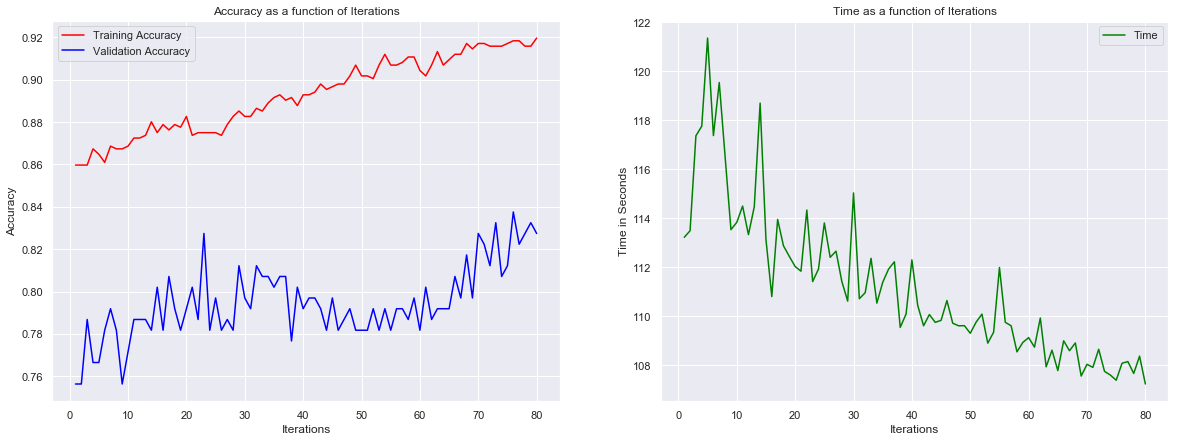

In [25]:
fig, axes = plt.subplots(1, 2,figsize=(20, 7), sharey=False)

# Plot both accuracies 
ax = axes[0]
sns.lineplot(iterations, accu_train, ax=ax,label="Training Accuracy", color="Red")
sns.lineplot(iterations, accu_val, ax=ax, label="Validation Accuracy", color="Blue")
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of Iterations')
ax.legend()

# Plot the time
ax = axes[1]
sns.lineplot(iterations, time, ax=ax, label="Time", color="Green")
ax.set_xlabel('Iterations')
ax.set_ylabel('Time in Seconds')
ax.set_title('Time as a function of Iterations')
ax.legend()

plt.show()

In [26]:
# Total amount of time
print("Total time in seconds:", total_time)
print("Total time in hours  :", (total_time/60)/60)

Total time in seconds: 8895.905698537827
Total time in hours  : 2.4710849162605073


## Part 4: Result Exploration

- Present the data
- Visualize different distrabutions of each gene
- Statistical inference

In [27]:
# Gather only relevant data (~100 features)
data_selected = data[list(selected_features)+['isLumA']]
data_selected

Unnamed: 0     PMEPA1     GRIN1     IFNB1  ADAMTSL2     SCN2B      MYBL2  \
DO1249       9.808517  4.595120  0.000000  5.886104  2.484907   8.427268   
DO1250       8.946245  3.295837  3.761200  6.582025  2.564949   7.081709   
DO1251       9.182044  4.905275  0.000000  7.077498  1.609438   8.548110   
DO1252       9.855452  4.007333  0.693147  6.198479  0.693147   9.176990   
DO1253      10.150348  2.944439  0.000000  7.596894  5.537334   6.354370   
...               ...       ...       ...       ...       ...        ...   
DO6204      10.119324  3.465736  0.000000  6.617403  4.394449   8.004032   
DO6213       9.189219  4.976734  0.693147  6.135565  5.327876   5.598422   
DO6222       8.435549  3.091042  0.000000  5.805135  3.610918   6.516193   
DO6231       8.386173  5.003946  1.609438  6.481577  1.098612  10.168272   
DO6240       9.311633  4.330733  0.000000  6.820016  5.003946   7.528869   

Unnamed: 0     P2RY2     OXCT1      EYA2    CHST10  ...      RFX4    PRKAR2B  \
DO1249      5.010635  7.967627  7.183871  6.502790  ...  0.693147   8.707648   
DO1250      5.141664  6.327937  5.480639  6.927558  ...  1.098612   8.260234   
DO1251      6.001415  7.351158  4.969813  7.118826  ...  0.693147   7.899153   
DO1252      6.171701  7.577634  4.691348  4.859812  ...  0.000000   7.916443   
DO1253      6.234411  8.444192  7.700295  7.331060  ...  1.945910  10.384709   
...              ...       ...       ...       ...  ...       ...        ...   
DO6204      7.196687  7.667158  5.802118  5.043425  ...  0.000000  10.213836   
DO6213      4.691348  7.150701  5.556828  6.815640  ...  0.000000   7.376508   
DO6222      5.446737  7.496652  6.632002  6.802395  ...  0.693147   7.958926   
DO6231      6.378426  8.606668  8.868554  7.386471  ...  1.945910   6.734592   
DO6240      6.280396  8.321908  7.452402  6.308098  ...  0.000000   7.293018   

Unnamed: 0      RLN2      CSH2      COQ3     GPR27     GDF15     FADS2  \
DO1249      3.526361  0.000000  5.568345  2.197225  3.401197  7.801391   
DO1250      4.634729  0.000000  6.159095  4.532599  7.008505  7.799753   
DO1251      4.543295  0.000000  5.736572  3.295837  7.823246  7.602900   
DO1252      2.484907  0.000000  5.365976  0.000000  6.502790  9.782675   
DO1253      4.543295  0.000000  6.575076  3.178054  6.943122  8.659387   
...              ...       ...       ...       ...       ...       ...   
DO6204      1.098612  0.693147  6.102559  1.791759  6.553933  6.899723   
DO6213      4.499810  0.000000  5.648974  4.418841  5.480639  7.239215   
DO6222      3.433987  0.000000  5.384495  2.397895  5.575949  6.744059   
DO6231      6.685861  0.000000  7.408531  2.772589  9.421816  8.969033   
DO6240      4.077537  0.000000  5.771441  2.397895  5.505332  9.575816   

Unnamed: 0     APOL5  isLumA  
DO1249      0.000000       0  
DO1250      1.791759       0  
DO1251      1.098612       0  
DO1252      0.693147       0  
DO1253      1.945910       1  
...              ...     ...  
DO6204      1.386294       0  
DO6213      0.000000       1  
DO6222      0.000000       1  
DO6231      0.693147       0  
DO6240      0.000000       0  

[981 rows x 102 columns]

##### Using confidence intervals to determine for which numerical features we can state with confidence of 95% that the LumA population mean is larger/smaller than the non-LumA population mean.

In [28]:
z_critical = scipy.stats.norm.ppf(1-0.05/2)
isLumA = data_selected[data_selected.isLumA == 1]
non_LumA = data_selected[data_selected.isLumA == 0]
n = len(data_selected["PMEPA1"])
# We iterate through each non categorical data
for feature in selected_features:
    # Get the mean and variance for non_LumA
    non_LumA_mean = non_LumA[feature].mean()
    non_LumA_var = (non_LumA[feature]).var()
    # Get the mean and variance for LumA
    isLumA_mean = isLumA[feature].mean()
    isLumA_var = isLumA[feature].var()
    # Calc the standard error
    SE = np.sqrt((non_LumA_var / len(non_LumA)) + (isLumA_var / len(isLumA)))
    mean_diff = non_LumA_mean - isLumA_mean
    #confidence interval on the difference
    conf_interval = (mean_diff - z_critical * SE, mean_diff + z_critical * SE)
    # Print results
    print(f"Feature: {feature}")
    print("--------------------------------------")
    print(f"The non_LumA mean is: {non_LumA_mean:.2f} \nThe isLumA mean is: {isLumA_mean:.2f}")
    print(f"95% Confidence Interval:({conf_interval[0]:.3f},{conf_interval[1]:.3f})" '\n')

Feature: PMEPA1
--------------------------------------
The non_LumA mean is: 8.86 
The isLumA mean is: 9.03
95% Confidence Interval:(-0.258,-0.077)

Feature: GRIN1
--------------------------------------
The non_LumA mean is: 3.76 
The isLumA mean is: 4.21
95% Confidence Interval:(-0.604,-0.301)

Feature: IFNB1
--------------------------------------
The non_LumA mean is: 0.88 
The isLumA mean is: 0.54
95% Confidence Interval:(0.230,0.448)

Feature: ADAMTSL2
--------------------------------------
The non_LumA mean is: 5.86 
The isLumA mean is: 6.23
95% Confidence Interval:(-0.472,-0.276)

Feature: SCN2B
--------------------------------------
The non_LumA mean is: 2.88 
The isLumA mean is: 4.19
95% Confidence Interval:(-1.504,-1.114)

Feature: MYBL2
--------------------------------------
The non_LumA mean is: 8.11 
The isLumA mean is: 6.54
95% Confidence Interval:(1.456,1.697)

Feature: P2RY2
--------------------------------------
The non_LumA mean is: 5.81 
The isLumA mean is: 6.16
95% C

The isLumA mean is: 2.12
95% Confidence Interval:(0.095,0.333)

Feature: PBX3
--------------------------------------
The non_LumA mean is: 7.09 
The isLumA mean is: 7.35
95% Confidence Interval:(-0.362,-0.152)

Feature: DNAH3
--------------------------------------
The non_LumA mean is: 2.40 
The isLumA mean is: 2.02
95% Confidence Interval:(0.173,0.573)

Feature: CHKA
--------------------------------------
The non_LumA mean is: 7.64 
The isLumA mean is: 7.43
95% Confidence Interval:(0.142,0.287)

Feature: RANBP17
--------------------------------------
The non_LumA mean is: 5.47 
The isLumA mean is: 5.22
95% Confidence Interval:(0.106,0.386)

Feature: CYP4F2
--------------------------------------
The non_LumA mean is: 0.68 
The isLumA mean is: 1.12
95% Confidence Interval:(-0.590,-0.291)

Feature: ENTPD3
--------------------------------------
The non_LumA mean is: 4.97 
The isLumA mean is: 5.62
95% Confidence Interval:(-0.818,-0.486)

Feature: GSTT1
-------------------------------------

#### Drawing histograms for each feature. Inspect the observed distributions and then use MLE to plot, on the same figures, fits of the distributions.

In [89]:
def plot_histogram_mle(feature_index):
    bins = 40
    fig, axes = plt.subplots(1,5, figsize=(25,5))
    if feature_index == 0:
        fig.suptitle("Histograms and Fits (using MLE)", fontsize=25)
    df = data_selected[selected_features]

    for i in range(5):
        #max is used to get the correct range
        x = np.linspace(0,df[selected_features[feature_index]].max())
        #MLE-Run to find dist-params
        values = scipy.stats.norm.fit(df[selected_features[feature_index]])
        #create function to plot
        y = scipy.stats.norm(loc= values[0], scale=values[1]).pdf(x)
        z = scipy.stats.lognorm(s= values[1], scale=np.exp(values[0])).pdf(x)
        axes[i].plot(x,y, color="blue")
        axes[i].plot(x,z, color="green")
        axes[i].hist(df[selected_features[feature_index]], bins = bins, density=True, color="red")
        axes[i].set_title(selected_features[feature_index])
        axes[i].set_ylabel("Frequency")
        feature_index = feature_index + 1

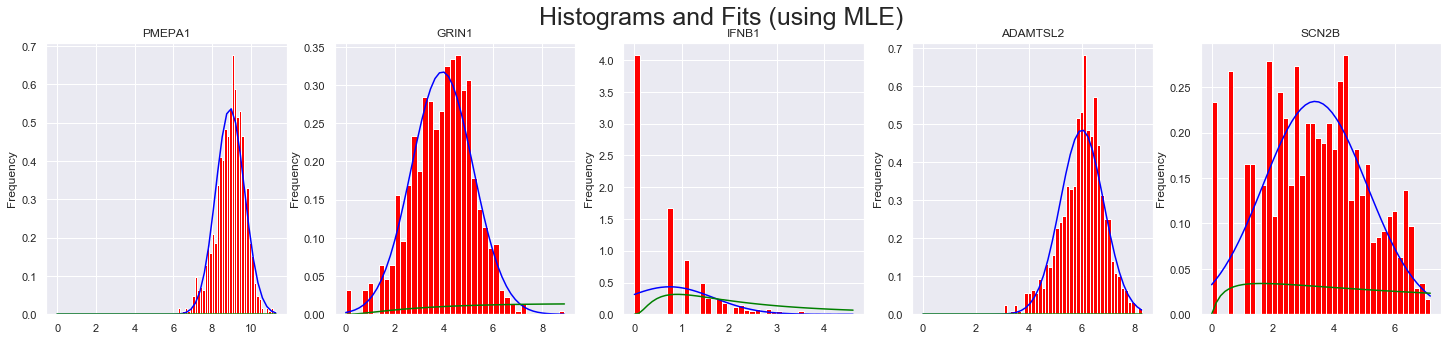

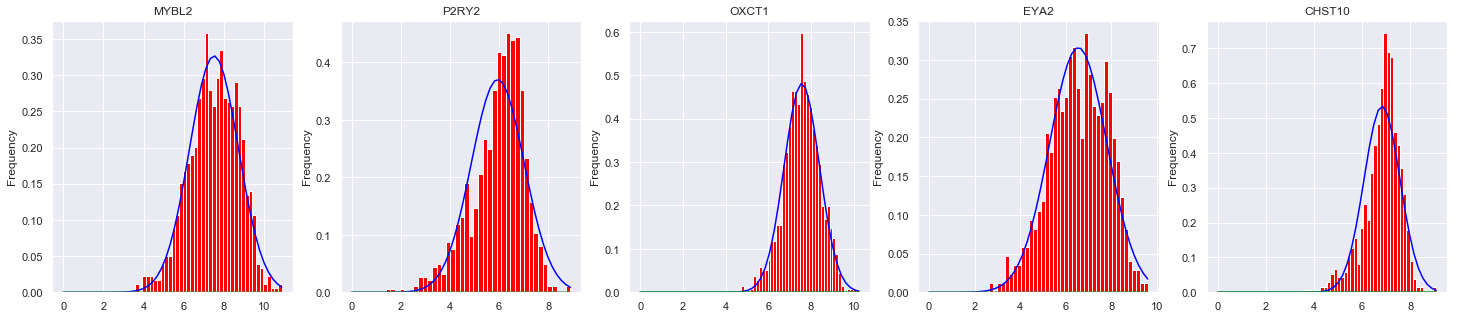

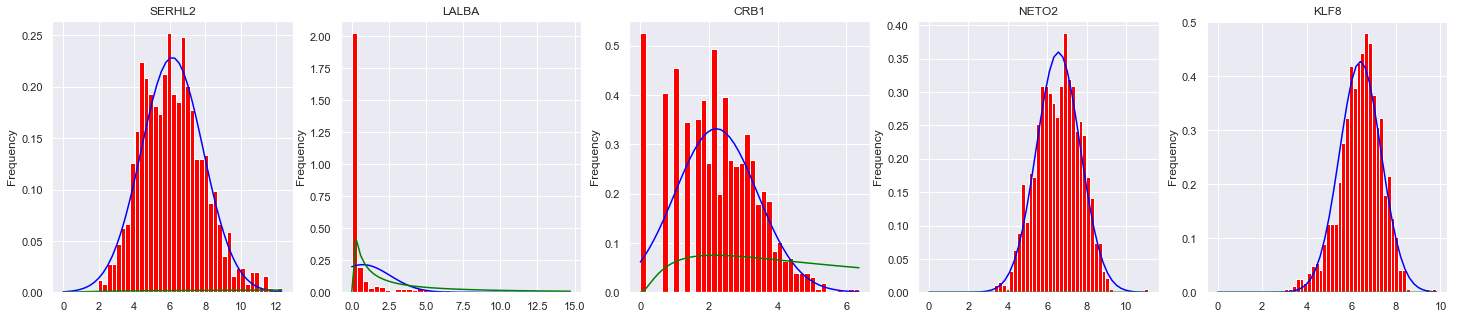

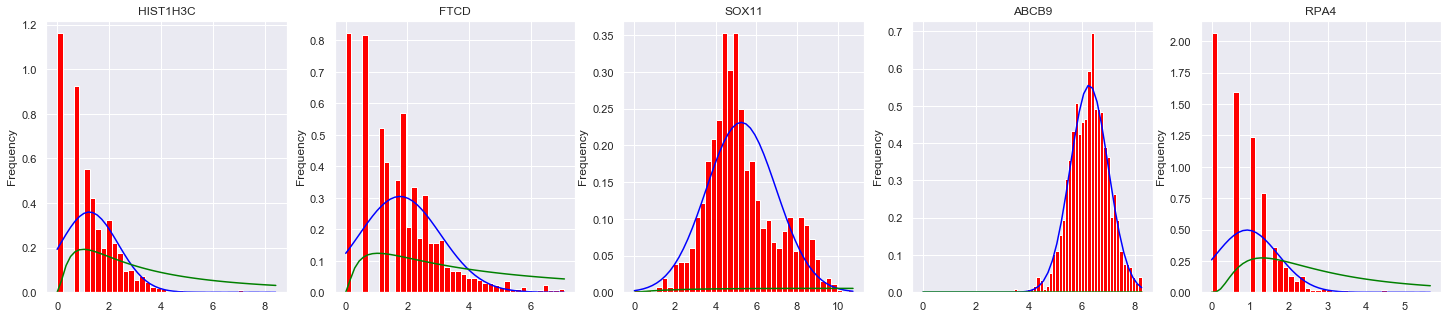

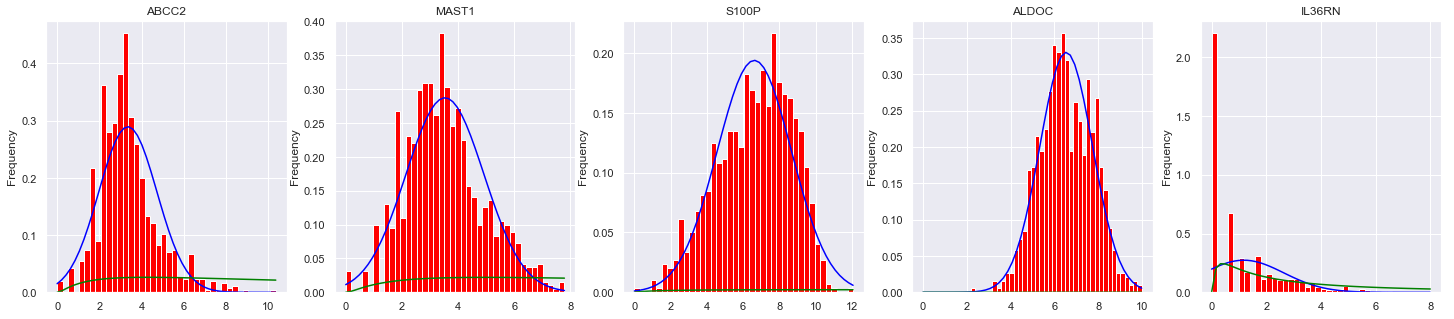

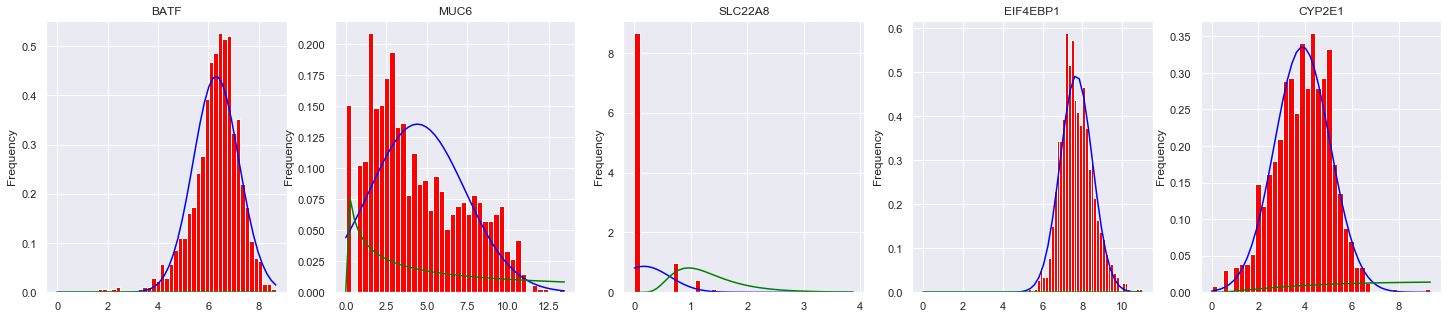

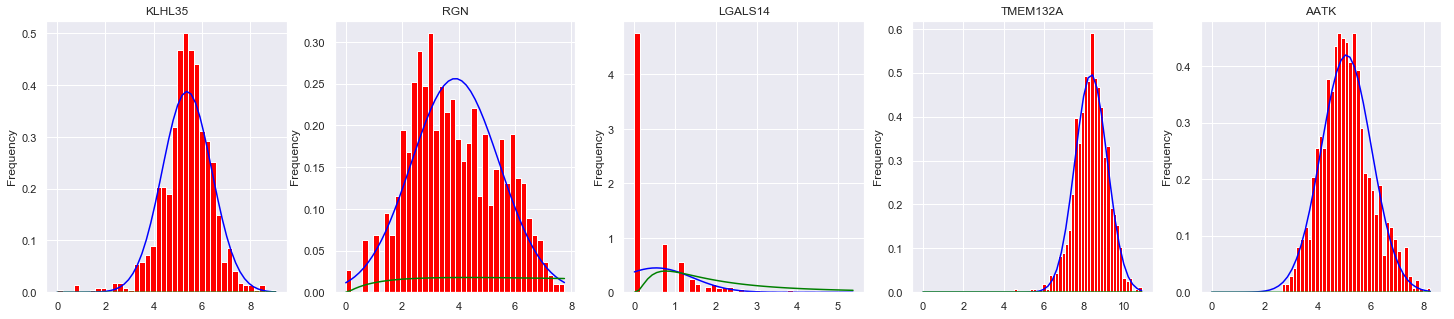

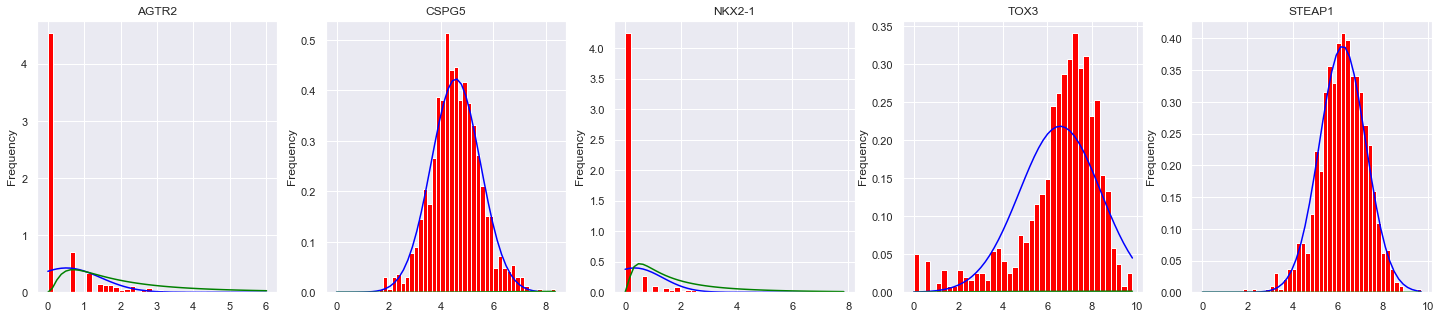

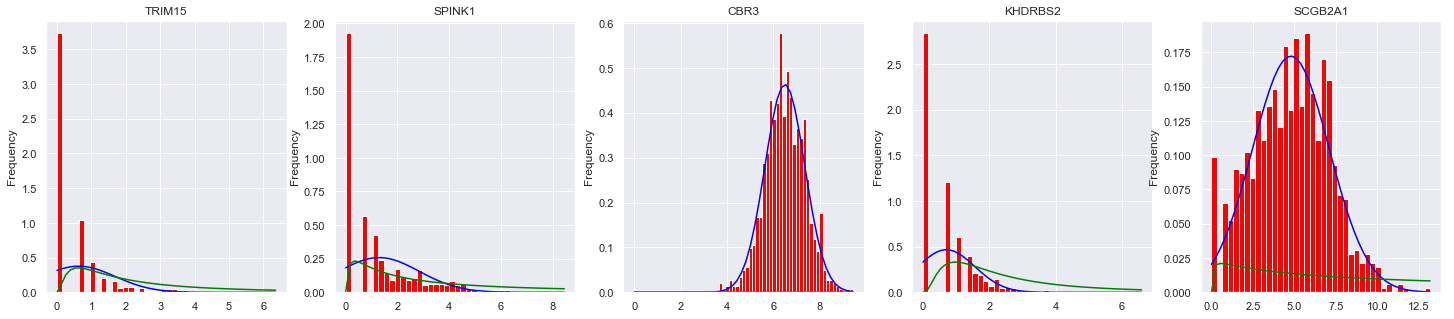

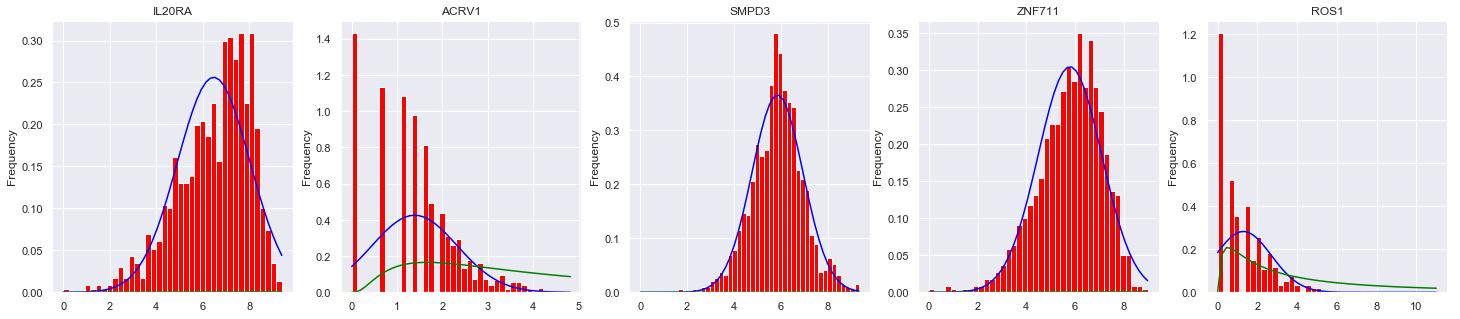

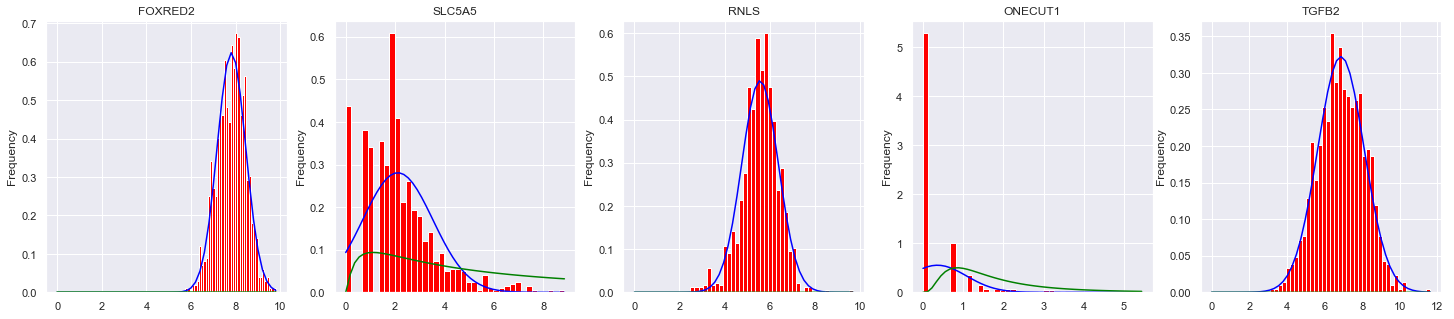

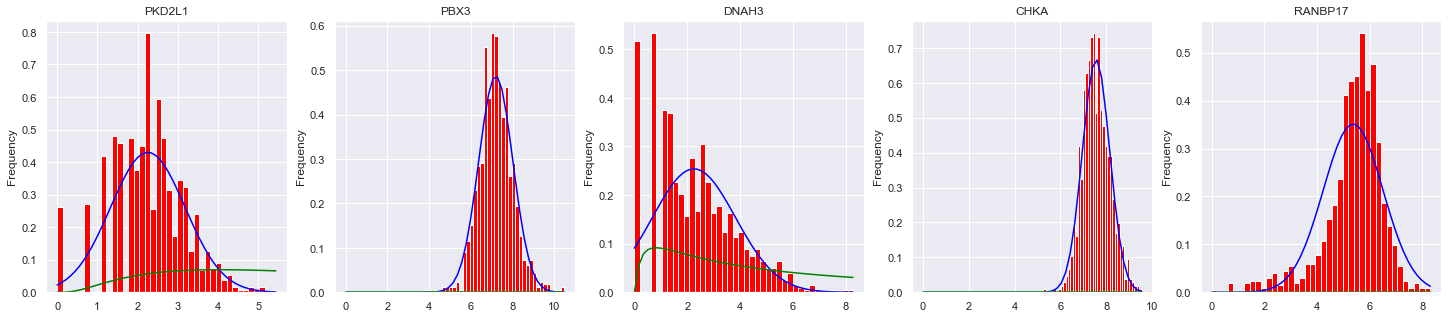

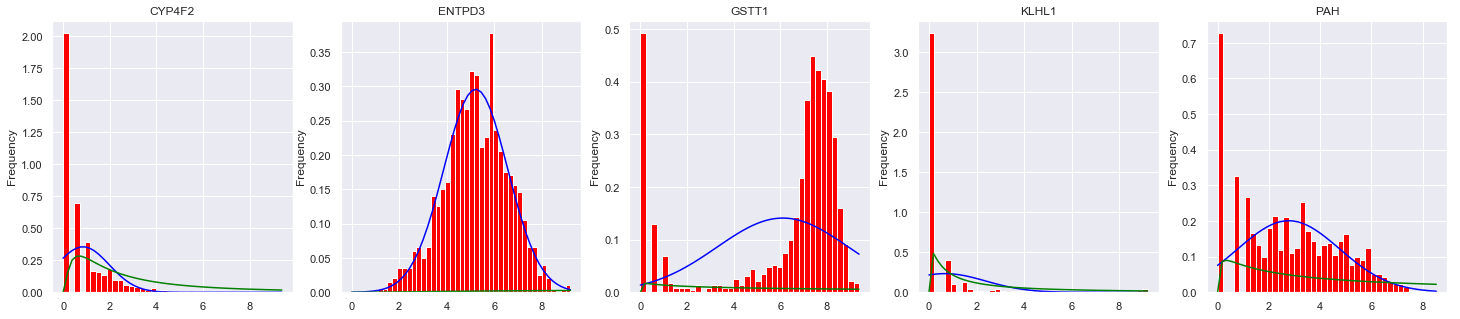

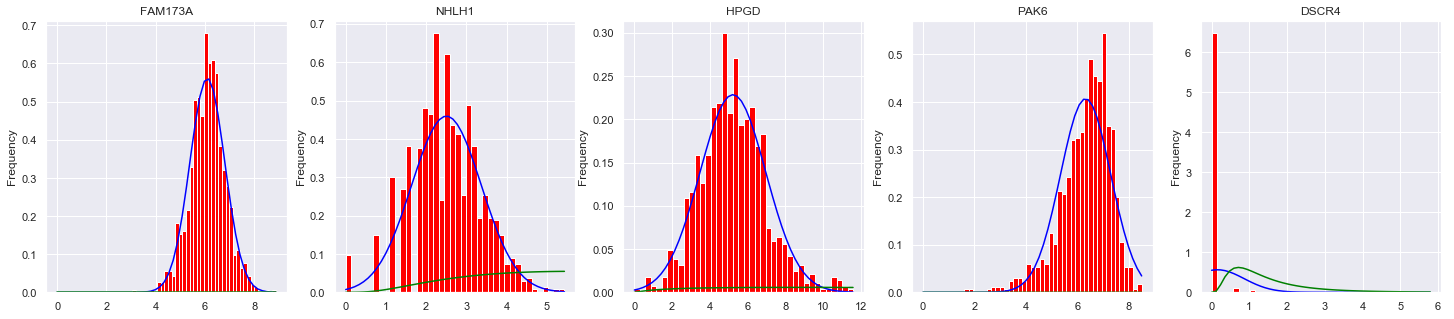

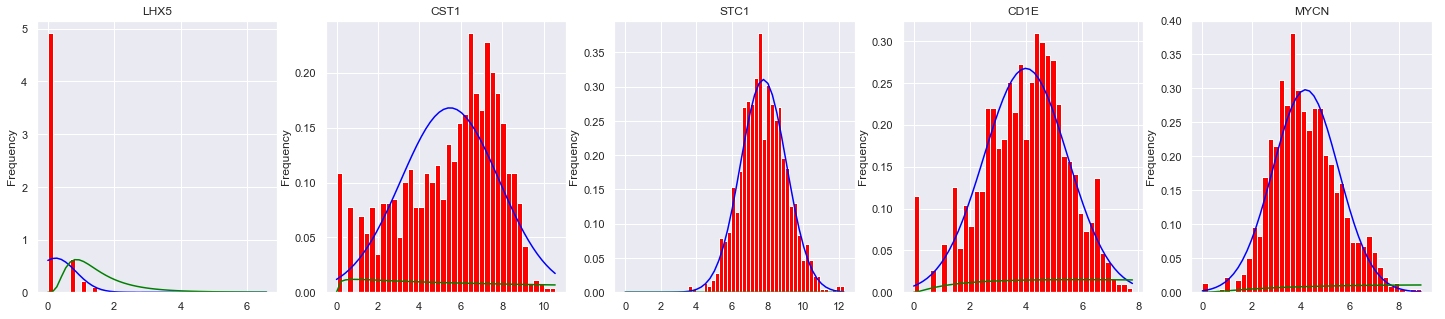

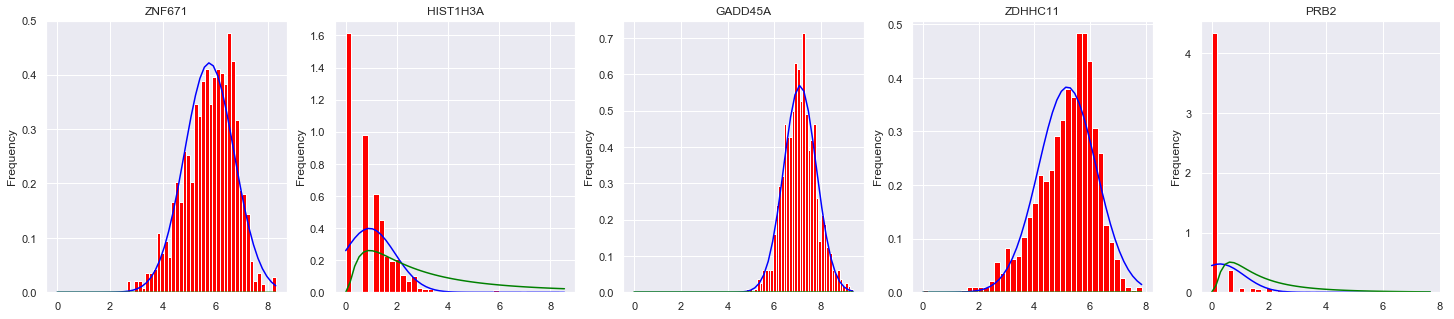

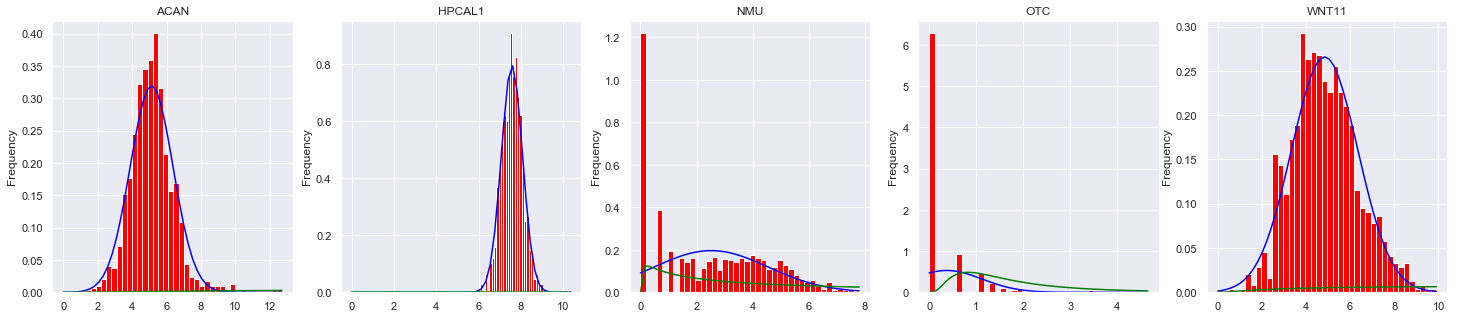

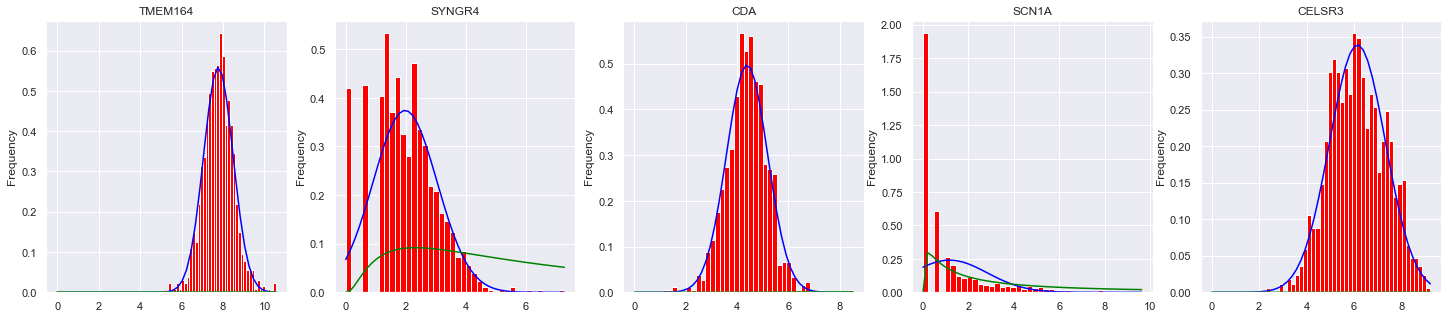

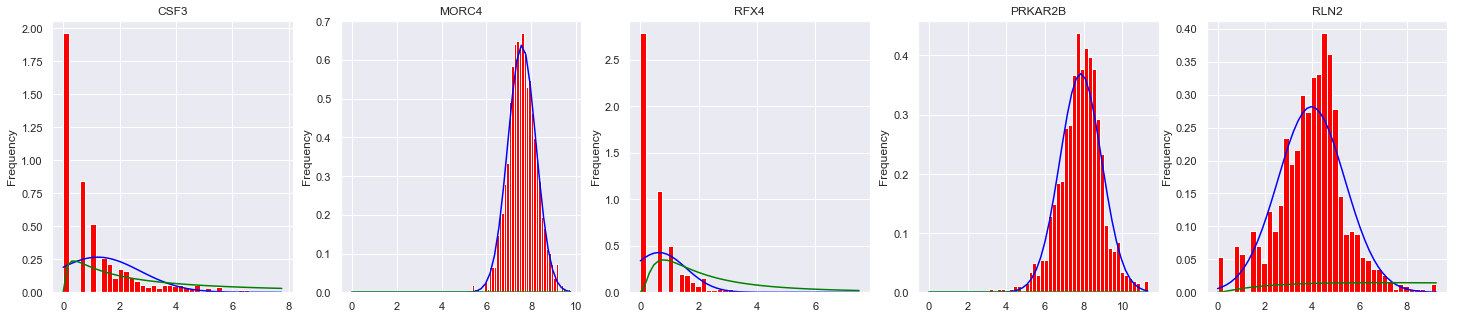

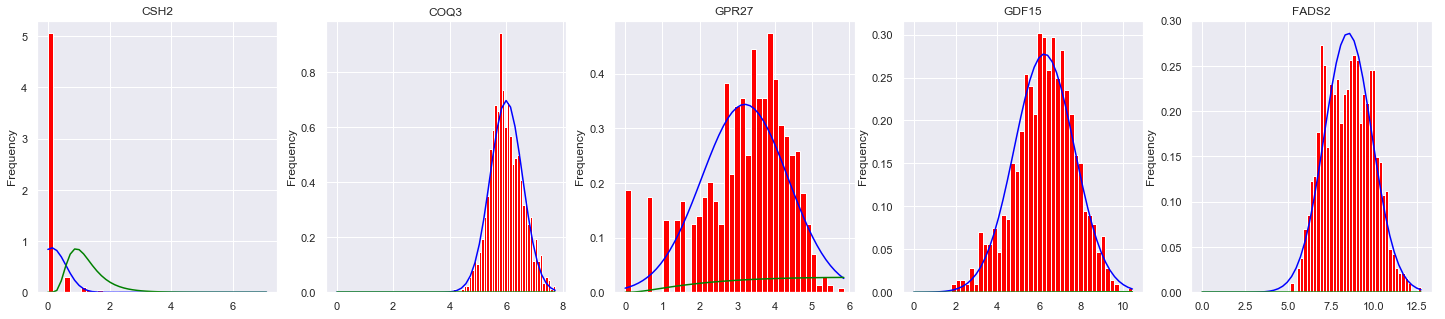

In [90]:
for i in range(0,100,5):
    plot_histogram_mle(i)

In [81]:
groups = data_selected.groupby(by='isLumA')
lumA = groups.get_group(1)
non_lumA = groups.get_group(0)

lumA_corr = lumA.drop(columns='isLumA').corr()
non_lumA_corr = non_lumA.drop(columns='isLumA').corr()

Text(0.5, 1.0, 'Correlations: lumA')

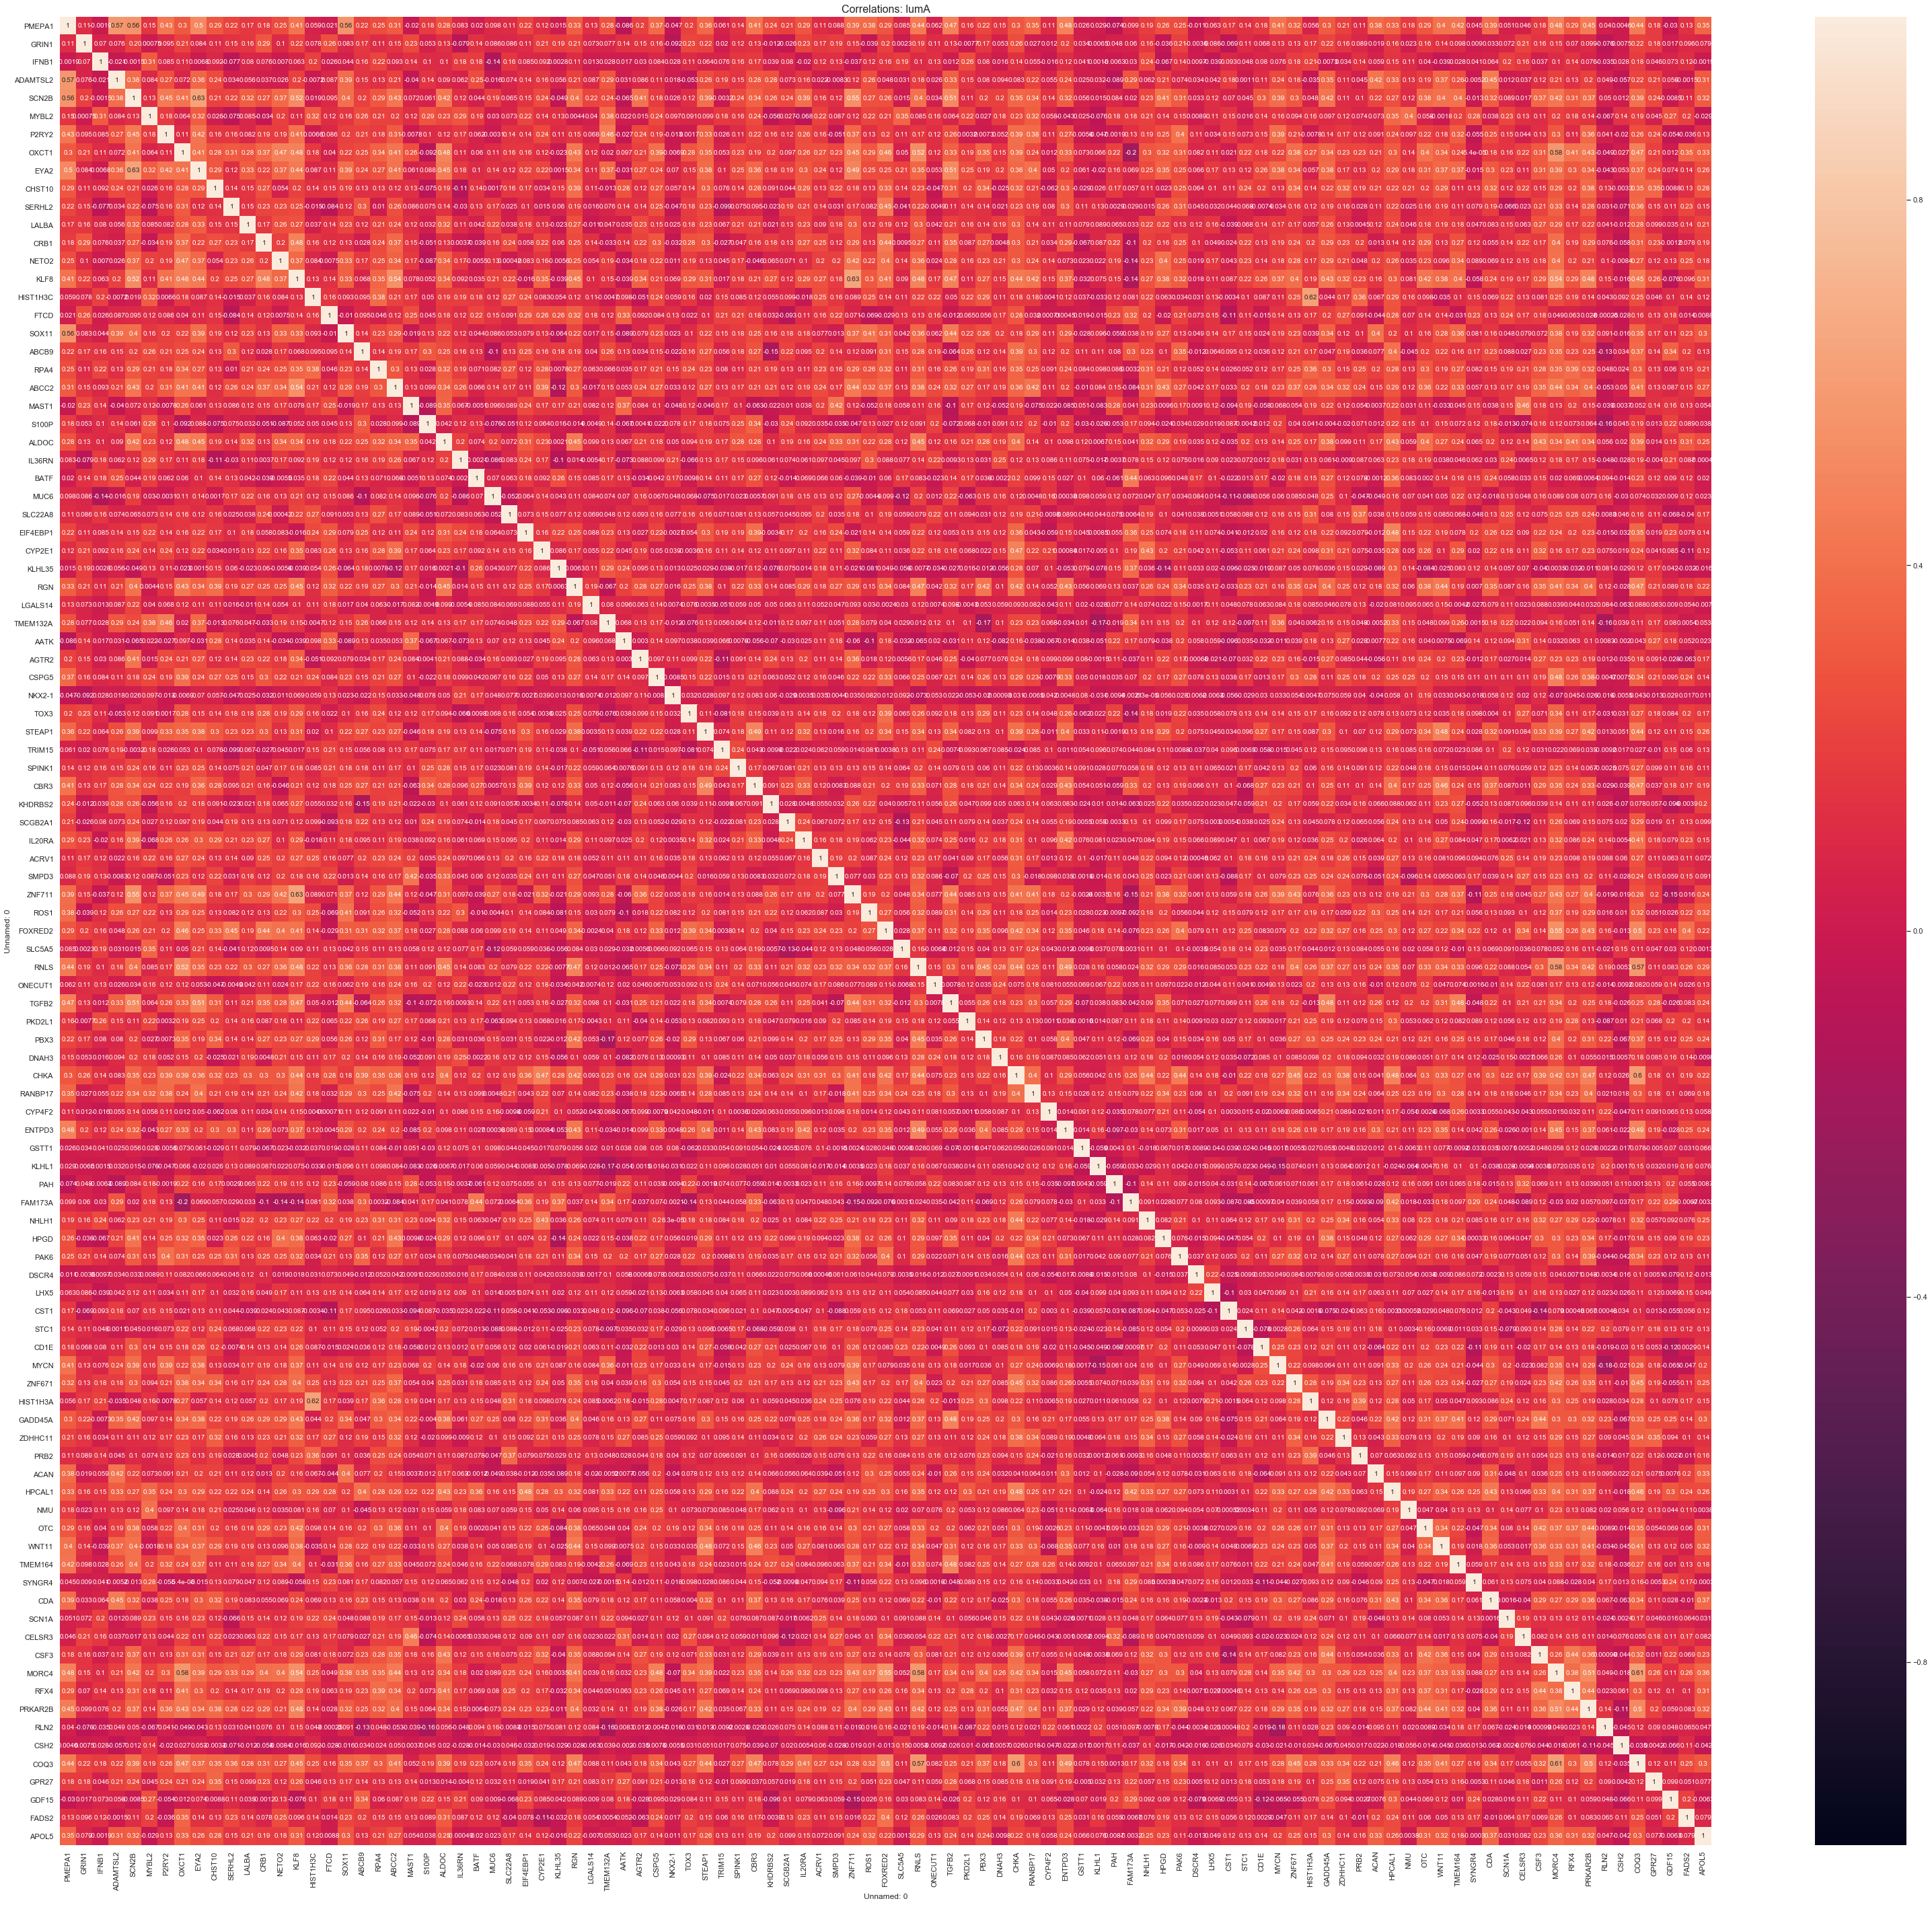

In [80]:
fig, axes = plt.subplots(ncols=1, figsize=(55,50))
sns.heatmap(lumA_corr, vmin=-1, vmax=1, annot=True, ax=axes)
axes.set_title('Correlations: lumA', fontsize=16)

Text(0.5, 1.0, 'Correlations: non_lumA')

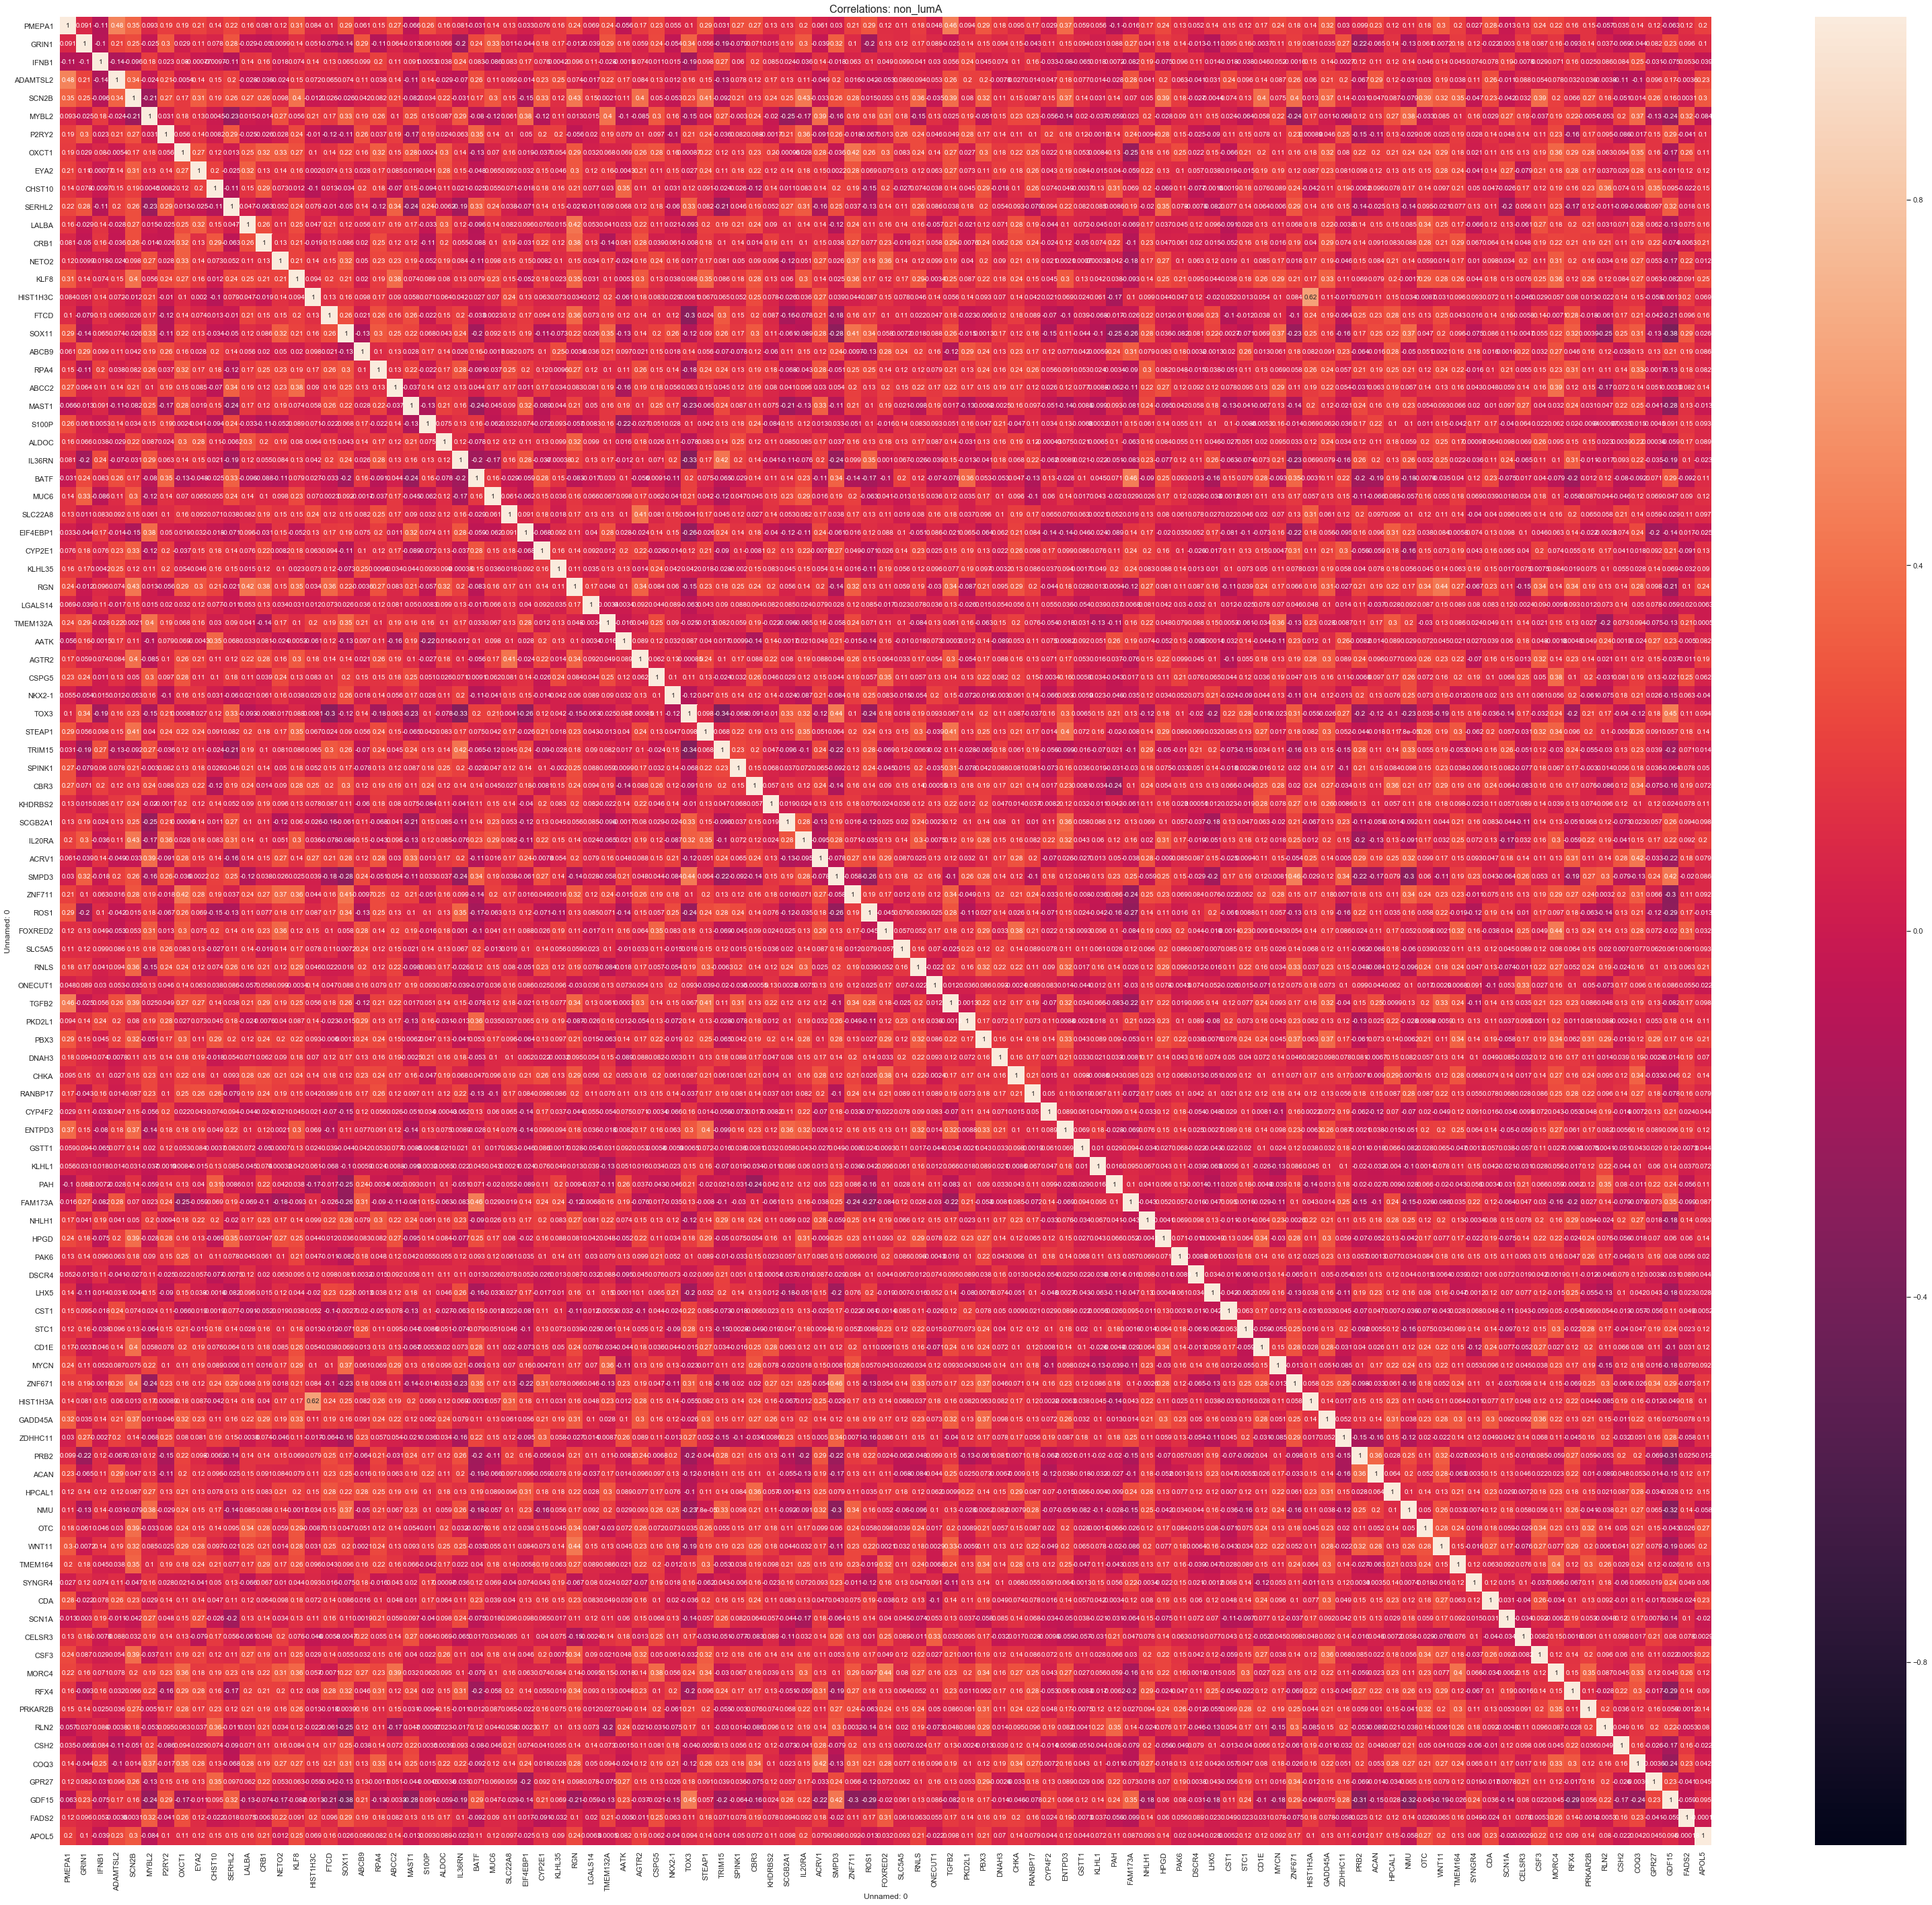

In [79]:
fig, axes = plt.subplots(ncols=1, figsize=(55,50))
sns.heatmap(non_lumA_corr, vmin=-1, vmax=1, annot=True, ax=axes)
axes.set_title('Correlations: non_lumA', fontsize=16)
